<div id="necessary_packages" >
    <h1 style="font-family:verdana;"> Overview </h1>
</div>

<ol style="font-family:verdana;font-size:1.1875rem;" >
    <li><a href="#necessary_packages">Necessary Packages</a></li>
    <li><a href="#global">Global</a></li>
    <li><a href="#utils">Utils</a></li>
    <li><a href="#reproducibility">Reproducibility</a></li>
    <li><a href="#eda">EDA</a></li>
    <li><a href="#data_loading">Data Loading</a></li>
    <li><a href="#modeling">Modeling</a></li>
    <li><a href="#training">Training</a></li>
</ol>

<div id="necessary_packages" >
    <h1 style="font-family:verdana;" >
        Necessary Packages
    </h1>
</div>

In [1]:
import os
import pandas as pd
import numpy as np
import random
import torch
import torchaudio
import wave
import seaborn as sns
from torch import nn,Tensor,optim
from torch.utils.data import Dataset,DataLoader
from typing import Callable,Optional
from torchinfo import summary
from torchmetrics.classification import MulticlassAccuracy,MulticlassF1Score
from torchmetrics import MetricCollection
from dataclasses import dataclass,field
from sklearn.model_selection import GroupShuffleSplit
from torchaudio import transforms as T
from IPython.display import Audio
from tqdm.auto import tqdm

In [2]:
sns.set_theme(palette='Set2')

<div id="global" >
    <h1 style="font-family:verdana;" >
        Global
    </h1>
</div>

In [3]:
DATA_DIR = '/kaggle/input/audio-mnist/data'

In [4]:
@dataclass
class Config:

    ### Seed for reproducibility
    seed : int = 42

    ### Device
    device : str = 'cuda' if torch.cuda.is_available() else 'cpu'

    ### Model
    in_channels : int = 1
    num_layers : int = 1
    channels : list[int] = field(default_factory=lambda:[8,16,32,64])
    num_classes : int = 10

    ### Hyperparameters
    learning_rate : float = 1e-3
    batch_size : int = 32
    epochs : int = 5

    ### Data
    num_workers : int = 4
    prefetch_factor : int = 2

In [5]:
config = Config()

<div id="utils" >
    <h1 style="font-family:verdana;" >
        Utils
    </h1>
</div>

In [6]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [7]:
def create_dataloaders(
    datasets : dict[str, Dataset],
    batch_size : int,
    num_workers : int,
    prefetch_factor : int,
    train_dataset : str = 'train',
) -> dict[str, DataLoader]:

    dataloaders = {}

    for key,dataset in datasets.items():

        dataloaders[key] = DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            prefetch_factor=prefetch_factor,
            shuffle=(key==train_dataset),
        )

    return dataloaders

In [8]:
def get_metadata(root : str) -> pd.DataFrame:

    metadata = {
        'path' : [],
        'label' : [],
        'person_id' : [],
        'recording_id' : [],
        'audio_length' : [],
        'sr' : []
    }

    subfolders = os.listdir(root)

    for subfolder in subfolders:
            
        subfolder_path = os.path.join(root, subfolder)

        if os.path.isdir(subfolder_path):
                
            audios = os.listdir(subfolder_path)

            for audio in tqdm(audios, desc=f"Processing {subfolder_path}"):

                audio_path = os.path.join(subfolder_path, audio)
                name,_ = os.path.splitext(audio)
                label,person_id,recording_id = name.split('_')
                
                metadata['path'].append(audio_path)
                metadata['label'].append(int(label))
                metadata['person_id'].append(int(person_id))
                metadata['recording_id'].append(int(recording_id))
                
                with wave.open(audio_path, 'r') as f:

                    frames = f.getnframes()
                    rate = f.getframerate()
                    duration = frames / float(rate)
                    
                    metadata['audio_length'].append(duration)
                    metadata['sr'].append(rate)

    return pd.DataFrame(metadata) 

<div id="reproducibility" >
    <h1 style="font-family:verdana;" >
        Reproducibility
    </h1>
</div>

In [9]:
seed_everything(config.seed)

<div id="eda" >
    <h1 style="font-family:verdana;" >
        EDA
    </h1>
</div>

In [10]:
metadata = get_metadata(DATA_DIR)

Processing /kaggle/input/audio-mnist/data/47:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/17:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/19:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/22:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/35:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/50:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/23:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/07:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/10:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/36:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/05:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/20:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/06:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/45:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/60:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/27:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/41:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/39:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/02:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/32:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/25:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/42:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/52:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/38:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/12:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/55:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/04:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/49:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/31:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/53:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/34:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/18:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/28:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/56:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/16:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/13:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/26:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/08:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/15:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/43:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/09:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/58:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/59:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/30:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/14:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/03:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/57:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/46:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/21:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/44:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/40:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/11:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/37:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/51:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/01:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/33:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/54:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/48:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/29:   0%|          | 0/500 [00:00<?, ?it/s]

Processing /kaggle/input/audio-mnist/data/24:   0%|          | 0/500 [00:00<?, ?it/s]

In [11]:
metadata.head()

,path,label,person_id,recording_id,audio_length,sr
0,/kaggle/input/audio-mnist/data/47/6_47_0.wav,6,47,0,0.829104,48000
1,/kaggle/input/audio-mnist/data/47/5_47_30.wav,5,47,30,0.705646,48000
2,/kaggle/input/audio-mnist/data/47/0_47_45.wav,0,47,45,0.671521,48000
3,/kaggle/input/audio-mnist/data/47/4_47_17.wav,4,47,17,0.587333,48000
4,/kaggle/input/audio-mnist/data/47/4_47_33.wav,4,47,33,0.768125,48000


In [12]:
metadata.describe()

,label,person_id,recording_id,audio_length,sr
count,30000.000000,30000.000000,30000.00000,30000.000000,30000.0
mean,4.500000,30.500000,24.50000,0.642593,48000.0
std,2.872329,17.318391,14.43111,0.111140,0.0
min,0.000000,1.000000,0.00000,0.293187,48000.0
25%,2.000000,15.750000,12.00000,0.560620,48000.0
50%,4.500000,30.500000,24.50000,0.632000,48000.0
75%,7.000000,45.250000,37.00000,0.716250,48000.0
max,9.000000,60.000000,49.00000,0.999958,48000.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


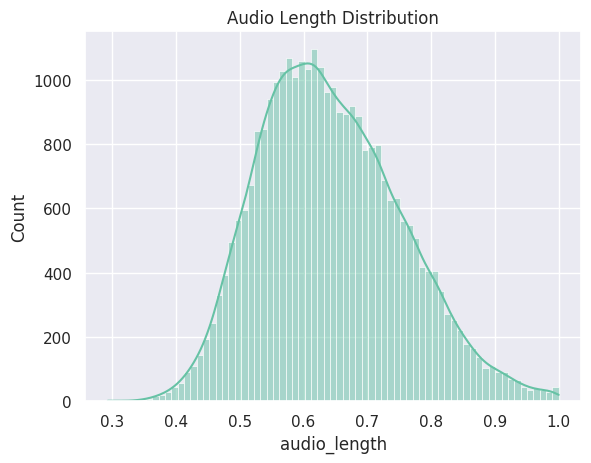

In [13]:
ax = sns.histplot(data=metadata, x='audio_length', kde=True)
_ = ax.set_title('Audio Length Distribution')

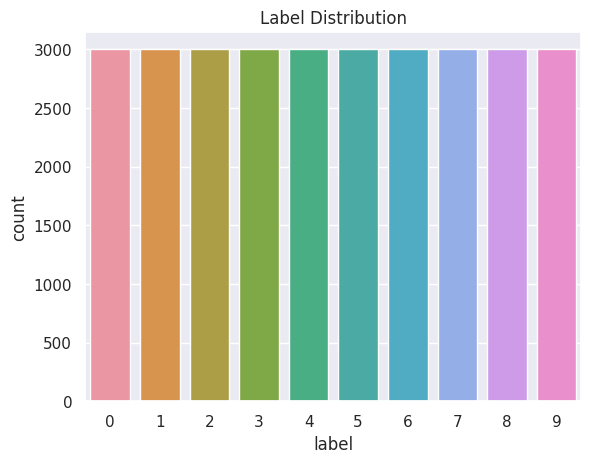

In [14]:
ax = sns.countplot(data=metadata, x='label')
_ = ax.set_title('Label Distribution')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


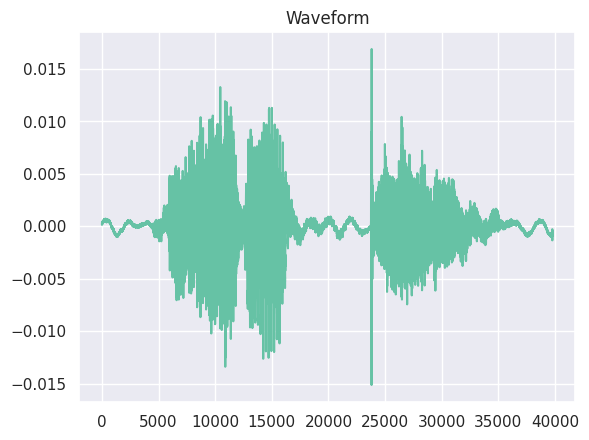

In [15]:
data,sr = torchaudio.load(metadata.iloc[0]['path'],normalize=True)
ax = sns.lineplot(data=data[0])
_ = ax.set_title('Waveform')

In [16]:
Audio(data[0],rate=48000)

In [17]:
mel_spectogram = T.MelSpectrogram(sample_rate=16000,n_fft=512,n_mels=64)
mel_spectogram(data).shape

torch.Size([1, 64, 156])

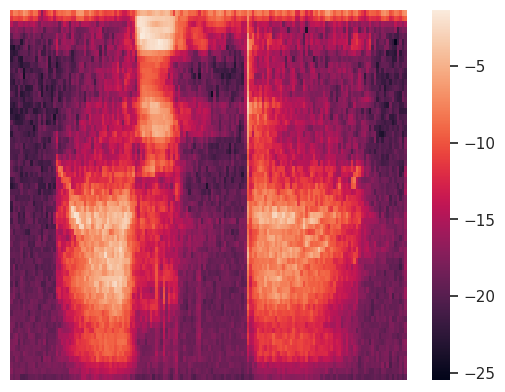

In [18]:
ax = sns.heatmap(mel_spectogram(data)[0].log2().detach().numpy())
_ = ax.axis('off')

<div id="data_loading" >
    <h1 style="font-family:verdana;" >
        Data Loading
    </h1>
</div>

In [19]:
class MnistAudioDataset(Dataset):

    def __init__(self, 
        metadata : pd.DataFrame,
        transform : Optional[Callable] = None,
        split : Optional[str] = None,
        seq_len : Optional[int] = None
    ) -> None:
        
        self.metadata = metadata
        self.transform = transform 
        self.split = split
        self.seq_len = seq_len

        if self.split is not None:
            self.metadata = self.metadata[self.metadata['split'] == split]

    def __len__(self) -> int:
        return len(self.metadata)
    
    def _adjust_audio_length(self,audio_data : Tensor) -> Tensor:

        C,L = audio_data.shape

        if L > self.seq_len:
            audio_data = audio_data[:,:self.seq_len]
        elif L < self.seq_len:
            pad = torch.zeros(C,self.seq_len - L)
            audio_data = torch.cat([audio_data,pad],dim=-1)

        return audio_data

    def __getitem__(self, index : int) -> dict:  

        row = self.metadata.iloc[index]
        audio_data,_ = torchaudio.load(row['path'],normalize=True,channels_first=True)

        if self.seq_len is not None:
            audio_data = self._adjust_audio_length(audio_data)

        if self.transform is not None:
            audio_data = self.transform(audio_data)

        data = {
            'label': row['label'],
            'person_id': row['person_id'],
            'recording_id': row['recording_id'],
            'data': audio_data
        }

        return data

In [20]:
def create_datasets(
    metadata : pd.DataFrame,
    test_size : float = 0.2,
    transform : Optional[Callable] = None
) -> tuple[MnistAudioDataset,MnistAudioDataset]:

    gss = GroupShuffleSplit(n_splits=1,test_size=test_size,random_state=config.seed)
    _,test_indices = next(iter(gss.split(metadata,groups=metadata['person_id'])))

    metadata['split'] = 'train'
    metadata.loc[test_indices,'split'] = 'test'

    train_data = MnistAudioDataset(metadata,transform=transform,split='train',seq_len=48000)
    test_data = MnistAudioDataset(metadata,transform=transform,split='test',seq_len=48000)

    return train_data,test_data

<div id="modeling" >
    <h1 style="font-family:verdana;" >
        Modeling
    </h1>
</div>

In [21]:
class ResBlock(nn.Module):

    def __init__(self,
        in_channels : int,
        out_channels : int,
        kernel_size : int = 3,
        stride : int = 1,
        padding : int = 1
    ) -> None:
        super(ResBlock, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride

        self.conv1 = nn.Conv2d(in_channels, out_channels,kernel_size=kernel_size,stride=stride,padding=padding)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=kernel_size,stride=stride,padding=padding)
        self.relu2 = nn.ReLU(inplace=True)

        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x : Tensor) -> Tensor:

        identity = self.shortcut(x)

        x = self.conv1(x)
        # x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        # x = self.bn2(x)

        x += identity
        x = self.relu2(x)

        return x

In [22]:
class BasicBlock(nn.Module):

    def __init__(self,
        in_channels : int,
        out_channels : int,
        num_layers : int
    ) -> None:
        super(BasicBlock, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_layers = num_layers

        self.layers = nn.ModuleList([
            ResBlock(
                in_channels=(in_channels if i == 0 else out_channels),
                out_channels=out_channels,
                kernel_size=3,
                stride=1,
                padding=1
            ) 
            for i in range(num_layers)
        ])

        self.downsample = nn.Conv2d(out_channels, out_channels, kernel_size=4, stride=2, padding=1)

    def forward(self, x : Tensor) -> Tensor:

        for layer in self.layers:
            x = layer(x)

        x = self.downsample(x)

        return x


In [23]:
class ResNet(nn.Module):

    def __init__(self,
        in_channels : int,
        channels : list[int],
        num_layers : int   ,
        num_classes : int,   
    ) -> None:
        super(ResNet, self).__init__()

        self.num_classes = num_classes
        self.channels = channels
        self.num_layers = num_layers

        self.conv1 = nn.Conv2d(in_channels,channels[0], kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU(inplace=True)

        self.blocks = nn.ModuleList([
            BasicBlock(
                in_channels=channels[i],
                out_channels=channels[i+1],
                num_layers=num_layers
            )
            for i in range(len(channels) - 1)
        ])

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(channels[-1], num_classes)

    def forward(self, x : Tensor) -> Tensor:

        x = self.conv1(x)
        # x = self.bn1(x)
        x = self.relu1(x)

        for block in self.blocks:
            x = block(x)

        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc(x)

        return x

In [24]:
model = ResNet(
    in_channels=1,
    num_classes=10,
    channels=[8,16,32,64],
    num_layers=1
)

In [25]:
summary(model, input_size=(16,1,64,128), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [16, 10]                  --
├─Conv2d: 1-1                            [16, 8, 64, 128]          80
├─ReLU: 1-2                              [16, 8, 64, 128]          --
├─ModuleList: 1-3                        --                        --
│    └─BasicBlock: 2-1                   [16, 16, 32, 64]          --
│    │    └─ModuleList: 3-1              --                        3,632
│    │    └─Conv2d: 3-2                  [16, 16, 32, 64]          4,112
│    └─BasicBlock: 2-2                   [16, 32, 16, 32]          --
│    │    └─ModuleList: 3-3              --                        14,432
│    │    └─Conv2d: 3-4                  [16, 32, 16, 32]          16,416
│    └─BasicBlock: 2-3                   [16, 64, 8, 16]           --
│    │    └─ModuleList: 3-5              --                        57,536
│    │    └─Conv2d: 3-6                  [16, 64, 8, 16]           

<div id="training" >
    <h1 style="font-family:verdana;" >
        Training
    </h1>
</div>

In [26]:
def train(config : Config) -> None:

    ### Load dataset
    transform = T.MelSpectrogram(sample_rate=16000,n_fft=512,n_mels=64)
    
    ### Split dataset
    train_dataset,val_dataset = create_datasets(
        metadata=metadata,
        test_size=0.2,
        transform=transform
    )

    ### Create dataloaders
    dataloaders = create_dataloaders(
        datasets={
            'train': train_dataset,
            'val': val_dataset
        },
        batch_size=config.batch_size,
        num_workers=config.num_workers,
        prefetch_factor=config.prefetch_factor
    )

    ### Model
    model = ResNet(
        in_channels=config.in_channels,
        channels=config.channels,
        num_layers=config.num_layers,
        num_classes=config.num_classes
    ).to(config.device)

    ### Loss
    loss_fn = nn.CrossEntropyLoss().to(config.device)

    ### Optimizer
    optimizer = optim.Adam(model.parameters(),lr=config.learning_rate)

    ### Metrics
    metrics = MetricCollection({
        "acc" : MulticlassAccuracy(num_classes=config.num_classes, average='micro'),
        "f1" : MulticlassF1Score(num_classes=config.num_classes,average='macro'),
    }).to(config.device)

    ### Training loop
    for epoch in range(config.epochs):

        for phase in ['train','val']:
            
            is_training = phase == 'train'
            loader = dataloaders[phase]

            model.train(is_training)

            iterator = tqdm(loader, desc=f"Epoch {epoch+1}/{config.epochs} - {phase} : ")

            phase_results = {
                key : 0.0
                for key in metrics.keys()
            }

            phase_results['loss'] = 0.0

            for batch in iterator:

                ### Move data to device
                batch['data'] = batch['data'].to(config.device)
                batch['label'] = batch['label'].to(config.device)

                ### Forward pass
                with torch.set_grad_enabled(is_training):
                    y_hat = model(batch['data'])

                ### Compute loss
                loss = loss_fn(y_hat,batch['label'])

                if is_training:

                    ### Zero gradients
                    optimizer.zero_grad()

                    ### Backward pass
                    loss.backward()

                    ### Update network
                    optimizer.step()

                ### Compute metrics
                results = metrics(y_hat, batch['label'])

                results = { 
                    key : value.cpu().item()
                    for key,value in results.items()
                }

                results['loss'] = loss.cpu().item()

                ### Logging
                iterator.set_postfix(results)

                ### Update Phase Results
                for key,value in results.items():
                    phase_results[key] += value / len(loader)

            msg = f"Epoch : {epoch+1}/{config.epochs} - {phase} : "

            for key,value in phase_results.items():
                msg += f"{key} = {value:.4f} | "

            print(msg)

In [27]:
train(config)

Epoch 1/5 - train :   0%|          | 0/750 [00:00<?, ?it/s]

Epoch : 1/5 - train : acc = 0.5561 | f1 = 0.4961 | loss = 1.2049 | 


Epoch 1/5 - val :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 1/5 - val : acc = 0.8843 | f1 = 0.8563 | loss = 0.4300 | 


Epoch 2/5 - train :   0%|          | 0/750 [00:00<?, ?it/s]

Epoch : 2/5 - train : acc = 0.9369 | f1 = 0.9211 | loss = 0.1900 | 


Epoch 2/5 - val :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 2/5 - val : acc = 0.9488 | f1 = 0.9374 | loss = 0.1638 | 


Epoch 3/5 - train :   0%|          | 0/750 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e827d606ef0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: Exception ignored in: can only test a child process<function _MultiProcessingDataLoaderIter.__del__ at 0x7e827d606ef0>

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    Exception ignored in: if w.i

Epoch : 3/5 - train : acc = 0.9697 | f1 = 0.9620 | loss = 0.0993 | 


Epoch 3/5 - val :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 3/5 - val : acc = 0.9591 | f1 = 0.9467 | loss = 0.1780 | 


Epoch 4/5 - train :   0%|          | 0/750 [00:00<?, ?it/s]

Epoch : 4/5 - train : acc = 0.9836 | f1 = 0.9790 | loss = 0.0511 | 


Epoch 4/5 - val :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 4/5 - val : acc = 0.9578 | f1 = 0.9502 | loss = 0.1695 | 


Epoch 5/5 - train :   0%|          | 0/750 [00:00<?, ?it/s]

Epoch : 5/5 - train : acc = 0.9837 | f1 = 0.9796 | loss = 0.0505 | 


Epoch 5/5 - val :   0%|          | 0/188 [00:00<?, ?it/s]

Epoch : 5/5 - val : acc = 0.9495 | f1 = 0.9366 | loss = 0.1639 | 
